# Quantum Fourier Transform Benchmark

In [1]:
low = 1
high = 27
samples = 10

In [2]:
import time
import random
import math

## PyQrack

In [3]:
%env QRACK_QUNITMULTI_DEVICES 1
from pyqrack import QrackSimulator, Pauli

def reverse_qrack(sim):
    start = 0
    end = sim.num_qubits() - 1
    while (start < end):
        sim.swap(start, end)
        start += 1
        end -= 1

env: QRACK_QUNITMULTI_DEVICES=1


### |0> initialization

In [4]:
def bench_qrack_0(n):
    sim = QrackSimulator(n, isOpenCL=False)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack.
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_0_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack_0(n))

    qrack_0_results[n] = sum(width_results) / samples

print(qrack_0_results)

{1: 4.458729999896604e-05, 2: 1.1623800310189835e-05, 3: 1.310520019615069e-05, 4: 1.447100039513316e-05, 5: 1.9153299945173785e-05, 6: 2.188140024372842e-05, 7: 2.010849930229597e-05, 8: 2.3141900237533263e-05, 9: 2.533270017011091e-05, 10: 3.352880048623774e-05, 11: 3.3856700611067936e-05, 12: 3.4415899426676334e-05, 13: 3.767609887290746e-05, 14: 4.124540027987678e-05, 15: 4.8115000390680505e-05, 16: 4.777909998665564e-05, 17: 5.3015400044387204e-05, 18: 6.128040004114155e-05, 19: 7.160379973356613e-05, 20: 6.66860996716423e-05, 21: 6.815110027673655e-05, 22: 7.194489917310421e-05, 23: 7.8776000009384e-05, 24: 8.296940068248659e-05, 25: 8.743389989831484e-05, 26: 0.00016750979993958027, 27: 9.728910081321373e-05}


### Random 1-qubit unitary initialization

In [5]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack,
    # so we give it a realistic case instead.
    for i in range(n):
        # Initialize with uniformly random single qubit gates, across full width.
        sim.u(i, random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi))
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_results[n] = sum(width_results) / samples

print(qrack_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{1: 1.042929980030749e-05, 2: 5.874830021639355e-05, 3: 0.00020246690073690842, 4: 0.00023733610032650176, 5: 0.00021713869937229903, 6: 0.00031041479924169834, 7: 0.00036959489989385474, 8: 0.0004967457996826851, 9: 0.0006466826998803299, 10: 0.000874208199820714, 11: 0.001586277300157235, 12: 0.0018992613997397712, 13: 0.002539076899847714, 14: 0.0033106220998888602, 15: 0.003396179899937124, 16: 0.0038669433000904974, 17: 0.004357409300428117, 18: 0.004948287199295009, 19: 0.0059936681995168325, 20: 0.00826992189977318, 21: 0.011916704300165292, 22: 0.017388464999385178, 23: 0.028812482699140673, 24: 0.054755695799758544, 25: 0.10073197540114051, 26: 0.19085357220028526, 27: 0.3769624300006399}


### GHZ state initialization

In [6]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    sim.h(0)
    for i in range(n - 1):
        sim.mcx([i], i + 1)
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_k_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_k_results[n] = sum(width_results) / samples

print(qrack_k_results)

{1: 7.112320054147858e-05, 2: 5.598770039796364e-05, 3: 0.00016536809926037677, 4: 0.0003965717995015439, 5: 0.0005867118001333438, 6: 0.0008809488004771993, 7: 0.0013212457000918222, 8: 0.0021145261995116015, 9: 0.003215495800031931, 10: 0.006074631800584029, 11: 0.012519967399930465, 12: 0.01344946619901748, 13: 0.015559883901005378, 14: 0.018686891499964987, 15: 0.021629444700010936, 16: 0.024122276999696622, 17: 0.02498213710023265, 18: 0.030553639800200472, 19: 0.0355608531004691, 20: 0.03857799409997824, 21: 0.04959010819984542, 22: 0.06933348729944555, 23: 0.1056601665004564, 24: 0.17202058839975506, 25: 0.30129021190041383, 26: 0.5487330718995509, 27: 1.0515840702002606}


## FFTW ("Classical" DFT)

In [7]:
import pyfftw
import numpy as np

# See https://blog.hpc.qmul.ac.uk/pyfftw.html
pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(60)
total_time = 0

### |0> initialization

In [8]:
fftw_0_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.zeros_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1.
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.ifft(io_array, overwrite_input=True, threads = (16 if (n > 20) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_0_results[n] = sum(width_results) / samples

print(fftw_0_results)

{1: 0.0001391553996654693, 2: 5.201719941396732e-05, 3: 5.456019935081713e-05, 4: 4.0586499744676983e-05, 5: 5.04266001371434e-05, 6: 4.263229966454674e-05, 7: 3.932669969799463e-05, 8: 3.98912001401186e-05, 9: 5.156160041224212e-05, 10: 4.4329399315756746e-05, 11: 5.135419924044982e-05, 12: 6.995650037424638e-05, 13: 0.00012405649977154098, 14: 0.00021591329968941863, 15: 0.0004266088999429485, 16: 0.0009361019994685194, 17: 0.0010409141006675782, 18: 0.0023390035992633786, 19: 0.008185351699285092, 20: 0.016363405700030854, 21: 0.048724017999484205, 22: 0.07309485930018127, 23: 0.1255365246997826, 24: 0.24074008670031616, 25: 0.4458421837996866, 26: 1.026122882799973, 27: 2.04386379259995}


### Random 1-qubit unitary initialization

In [9]:
fftw_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.empty_aligned(2**n, dtype=np.complex64)
        
        # Use Qrack to initialize the test case!
        sim = QrackSimulator(n)
        for i in range(n):
            # Initialize with uniformly random single qubit gates, across full width.
            sim.u(i, random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi))
        ket = sim.out_ket()
        del sim
        for i in range(2**n):
            io_array[i] = ket[i]
        del ket
        
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.ifft(io_array, overwrite_input=True, threads = (16 if (n > 20) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_results[n] = sum(width_results) / samples

print(fftw_results)

{1: 4.334159966674633e-05, 2: 3.752429984160699e-05, 3: 3.825809944828507e-05, 4: 4.111069902137388e-05, 5: 4.156579998380039e-05, 6: 3.8480199509649535e-05, 7: 3.8168999162735416e-05, 8: 3.553180031303782e-05, 9: 3.688810029416345e-05, 10: 4.080370017618406e-05, 11: 4.569729971990455e-05, 12: 5.772050062660128e-05, 13: 7.952929991006386e-05, 14: 0.00012735710115521214, 15: 0.00024803750020510054, 16: 0.0004874691989243729, 17: 0.001044219899995369, 18: 0.002253004499652889, 19: 0.00857731879950734, 20: 0.015998616099386707, 21: 0.04466645969987439, 22: 0.06876870619998954, 23: 0.12807564140020986, 24: 0.2351292373998149, 25: 0.42427915440057407, 26: 0.9984989976994256, 27: 2.1693398547999094}


### GHZ initialization

In [10]:
fftw_k_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.zeros_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1 / math.sqrt(2)
        io_array[2**n - 1] = 1 / math.sqrt(2)
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.ifft(io_array, overwrite_input=True, threads = (16 if (n > 20) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_k_results[n] = sum(width_results) / samples

print(fftw_k_results)

{1: 0.00012898619970656, 2: 3.850559951388277e-05, 3: 4.169500061834697e-05, 4: 6.550910002260935e-05, 5: 2.969999986817129e-05, 6: 4.938079982821364e-05, 7: 2.5375499535584823e-05, 8: 2.1987900254316628e-05, 9: 2.3316599981626496e-05, 10: 3.5539099189918486e-05, 11: 2.935619959316682e-05, 12: 8.543870026187506e-05, 13: 0.00010881600028369575, 14: 0.00010481320023245644, 15: 0.0002611102998343995, 16: 0.00040650899973115884, 17: 0.0008890344000974437, 18: 0.002146276099301758, 19: 0.007970157799354638, 20: 0.016704786900663748, 21: 0.05732369469988043, 22: 0.07154520839976612, 23: 0.12639019850030309, 24: 0.22978379630003473, 25: 0.4327616697999474, 26: 1.0052100737000729, 27: 1.977346583300823}


## Qiskit Aer

In [11]:
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

def reverse_aer(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.swap(start, end)
        start += 1
        end -= 1

# Implementation of the Quantum Fourier Transform
def aer_qft(num_qubits, circ):
    # Quantum Fourier Transform
    for j in range(num_qubits):
        for k in range(j):
            circ.cp(math.pi/float(2**(j-k)), j, k)
        circ.h(j)
    reverse_aer(num_qubits, circ)
    for j in range(num_qubits):
        circ.measure(j, j)

    return circ

sim_backend = QasmSimulator(shots=1, method='statevector_gpu')

def bench_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    aer_qft(num_qubits, circ)
    start = time.perf_counter()
    job = execute([circ], sim_backend, timeout=600)
    result = job.result()
    return time.perf_counter() - start

aer_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_aer(n))

    aer_results[n] = sum(width_results) / samples

print(aer_results)

{1: 0.022294172900001286, 2: 0.004121251800097525, 3: 0.004433394400257385, 4: 0.00525155859941151, 5: 0.005993348000629339, 6: 0.006754010299846414, 7: 0.008001708998563117, 8: 0.0088594387001649, 9: 0.009308657900328398, 10: 0.010968102799597545, 11: 0.01253522500010149, 12: 0.012399153799924534, 13: 0.013961678000123356, 14: 0.014073715800259378, 15: 0.016888465100055327, 16: 0.01713496420015872, 17: 0.02224565670003358, 18: 0.021896037100304966, 19: 0.0243308759003412, 20: 0.03034102020028513, 21: 0.043395522399805486, 22: 0.06386146200020448, 23: 0.10529798159986967, 24: 0.19856645829968328, 25: 0.3867210231986974, 26: 0.8243388001999847, 27: 1.6755723577996833}


## Qulacs

In [12]:
import qulacs

def reverse_qulacs(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.add_gate(qulacs.gate.SWAP(start, end))
        start += 1
        end -= 1

def get_rotz(exponent: float) -> np.ndarray:
    return np.diag([1., np.exp(1.j * np.pi * exponent)])

def bench_qulacs(n):
    sim = qulacs.QuantumStateGpu(n)
    circ = qulacs.QuantumCircuit(n)
    start = time.perf_counter()

    for j in range(n):
        for k in range(j):
            mat = get_rotz(math.pi/float(2**(j-k)))
            gate = qulacs.gate.DenseMatrix(k, mat)
            gate.add_control_qubit(j, 1)
            circ.add_gate(gate)
        circ.add_gate(qulacs.gate.H(j))
    reverse_qulacs(n, circ)
    for index in range(n):
        circ.add_gate(qulacs.gate.Measurement(index, index))

    circ.update_quantum_state(sim)

    return time.perf_counter() - start

qulacs_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qulacs(n))

    qulacs_results[n] = sum(width_results) / samples

print(qulacs_results)

{1: 0.00015667819970985875, 2: 0.00037527999957092105, 3: 0.000520437700470211, 4: 0.0007175098999141483, 5: 0.0008916620012314524, 6: 0.0011658422998152673, 7: 0.001387678199898801, 8: 0.0017003405999275855, 9: 0.001888029800102231, 10: 0.002118310000150814, 11: 0.0025745730003109203, 12: 0.0031709573995613027, 13: 0.003602133299500565, 14: 0.003972549800164415, 15: 0.004427720799503732, 16: 0.00720373749936698, 17: 0.01114365129978978, 18: 0.015264325900716358, 19: 0.023992786999951932, 20: 0.04335080520068004, 21: 0.08446971400044276, 22: 0.1687015544001042, 23: 0.33399298440017444, 24: 0.6686029674012388, 25: 1.3548834172001079, 26: 2.7661466134006334, 27: 5.698119341699567}


## QCGPU

In [13]:
%env PYOPENCL_CTX 1

env: PYOPENCL_CTX=1


In [14]:
import qcgpu

def swap_qcgpu(circ, q1, q2):
    circ.cx(q1, q2)
    circ.cx(q2, q1)
    circ.cx(q1, q2)
    
def reverse_qcgpu(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        swap_qcgpu(circ, start, end)
        start += 1
        end -= 1

def bench_qcgpu(num_qubits):
    state = qcgpu.State(num_qubits)
    start = time.perf_counter()
 
    for j in range(num_qubits):
        for k in range(j):
            state.cu1(j, k, math.pi/float(2**(j-k)))
        state.h(j)
    reverse_qcgpu(num_qubits, state)
    state.measure()

    state.backend.queue.finish()
    return time.perf_counter() - start

qcgpu_results = {}
for n in range(low, high + 1):
    width_results = []
         
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qcgpu(n))

    qcgpu_results[n] = sum(width_results) / samples

print(qcgpu_results)

{1: 0.0012292310006159824, 2: 0.0019585850001021753, 3: 0.002567200199700892, 4: 0.00420410409969918, 5: 0.005105598100635688, 6: 0.006676112200148054, 7: 0.00783536659910169, 8: 0.009663132099740323, 9: 0.01202814629978093, 10: 0.014796718600700842, 11: 0.01732954750004865, 12: 0.02050762039980327, 13: 0.023607544499463985, 14: 0.0272660167007416, 15: 0.030916816600074525, 16: 0.03524133060054737, 17: 0.039901539199127, 18: 0.04613648180020391, 19: 0.052802486599830445, 20: 0.0633493809003994, 21: 0.07909424300050887, 22: 0.11057713249974768, 23: 0.17158187220047694, 24: 0.35416394049971134, 25: 0.731800097598898, 26: 1.522141361199465, 27: 3.139945993199581}


## Results

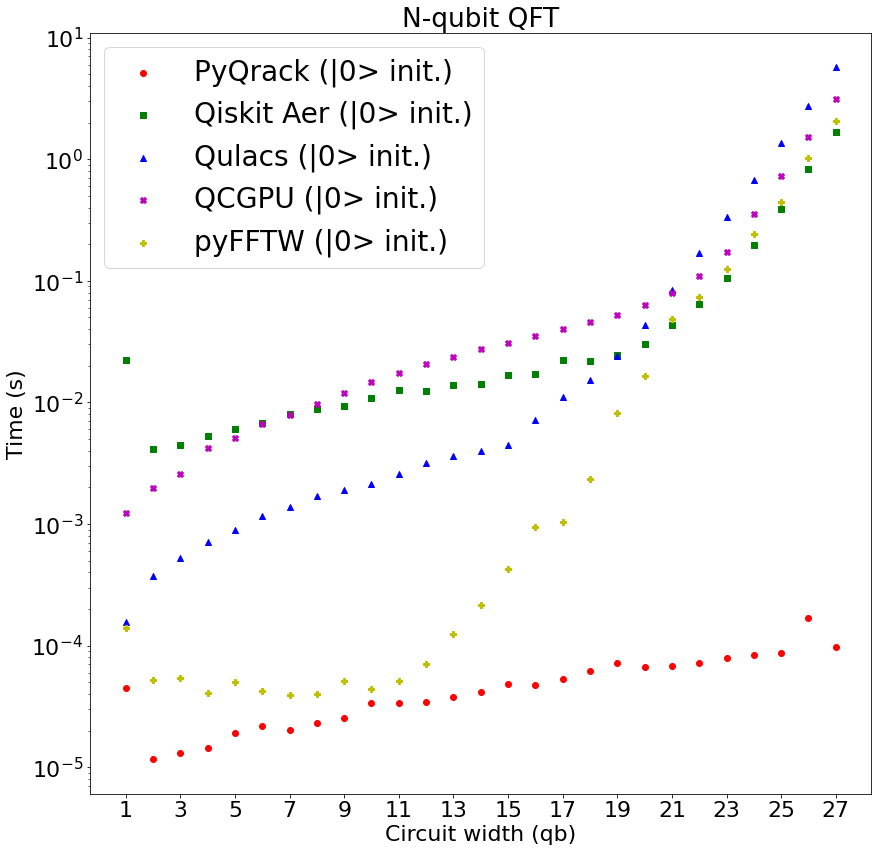

In [27]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.rc('legend',fontsize=28)
plt.rcParams.update({'font.size': 22})

colors = list("kcymbgr")
markers = list("*PX^so")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = aer_results.keys()
y = aer_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qulacs_results.keys()
y = qulacs_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qcgpu_results.keys()
y = qcgpu_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_0_results.keys()
y = fftw_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

plt.title("N-qubit QFT")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (|0> init.)", "Qiskit Aer (|0> init.)", "Qulacs (|0> init.)", "QCGPU (|0> init.)", "pyFFTW (|0> init.)"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=2))

plt.show()

fig.savefig('qft_0_chart.png', dpi=100)

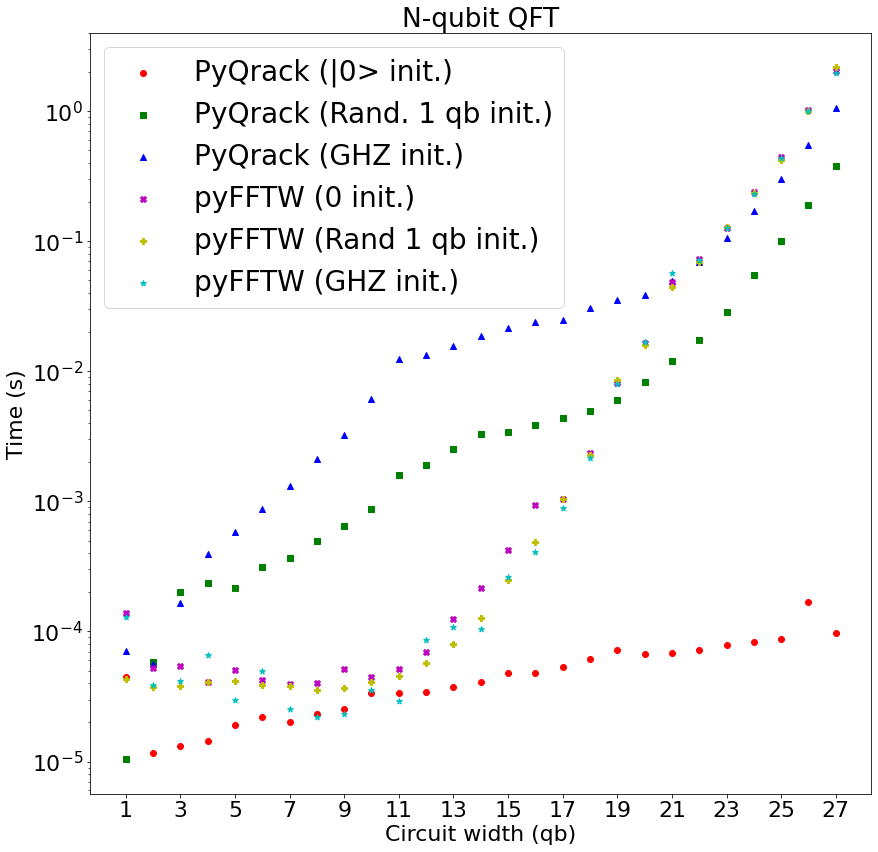

In [28]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.rc('legend',fontsize=28)
plt.rcParams.update({'font.size': 22})

colors = list("cymbgr")
markers = list("*PX^so")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qrack_results.keys()
y = qrack_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qrack_k_results.keys()
y = qrack_k_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_0_results.keys()
y = fftw_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_results.keys()
y = fftw_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_k_results.keys()
y = fftw_k_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

plt.title("N-qubit QFT")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (|0> init.)", "PyQrack (Rand. 1 qb init.)", "PyQrack (GHZ init.)", "pyFFTW (0 init.)", "pyFFTW (Rand 1 qb init.)", "pyFFTW (GHZ init.)"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=2))

plt.show()

fig.savefig('qft_ghz_chart.png', dpi=100)

In [17]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#33~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jan 30 17:03:34 UTC 2
Linux-5.19.0-32-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-32-generic', version='#33~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jan 30 17:03:34 UTC 2', machine='x86_64')
Linux
x86_64


In [18]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [19]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'